In [1]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import vmap, jacrev
from IPython.display import display, Math
import matplotlib
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
matplotlib.rcParams['font.size']= 25
matplotlib.rcParams['font.family']= 'ptm' #'Times New Roman

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
#Based on the implementation of H2 in
#https://github.com/DecodEPFL/HamiltonianNet/blob/master/integrators/integrators.py
class HNN(nn.Module):
    # Hamiltonian neural network
    # General ODE: \dot{y} = [ 0 I ; -I 0 ] K(t) \tanh( K^T(t) y(t) + b(t) )
    # Discretization method: Symplectic Euler
    def __init__(self, n_layers=10, h=0.1, nf=4, nout=1, dtype=torch.float32):
        super().__init__()

        self.n_layers = n_layers
        self.h = h
        self.nl = nn.Tanh()
        self.dtype = dtype
        
        if nf%2 == 0:
            self.nf = nf
        else:
            self.nf = nf+1
            print("Number of features need to be and even number -- setting nf = %i" % self.nf)

        #Masking the parameter so that we preserve the block diagonal structure while updating the weight K
        self.B = nn.Parameter(torch.randn(self.n_layers, self.nf//2, self.nf//2,dtype=self.dtype))
        self.C = nn.Parameter(torch.randn(self.n_layers, self.nf//2, self.nf//2,dtype=self.dtype))
        self.b = nn.Parameter(torch.randn(self.n_layers, self.nf//2,dtype=self.dtype))
        self.c = nn.Parameter(torch.randn(self.n_layers, self.nf//2,dtype=self.dtype))
        
        self.nout = nout #Output dimension
        self.projection = nn.Linear(self.nf,self.nout,dtype=self.dtype) #Last linear layer
        
        Id = torch.eye(self.nf//2,dtype=self.dtype)
        zero = torch.zeros((self.nf//2,self.nf//2),dtype=self.dtype)
        
        self.M1 = torch.cat((Id,zero),dim=0) #(q,p)@M1=q : gets the first half of the entries when right multiplied
        self.M2 = torch.cat((zero,Id),dim=0) #(q,p)@M2=p : gets the second half of the entries when right multiplied
        self.ZZ = torch.zeros_like(self.M1)
        self.up_1 = torch.cat((Id,zero),dim=1) #q@up_1 = (q,0)
        self.up_2 = torch.cat((zero,Id),dim=1) #p@up_2 = (0,p)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J
    
    def dynamics(self,Y,get_states=False):
        
        if get_states:
            hidden_layers = [Y]
        
        for j in range(self.n_layers):

            #Symplectic Euler Update
            transformed_q = self.nl(F.linear(Y@self.M2,self.B[j]) + self.b[j])
            Y = Y + self.h * F.linear(transformed_q,self.B[j].T) @ self.up_1 #in this way we only affect the second component
            if get_states:
                Y.retain_grad() #so we can compute the gradient with respect to this variable
                
            transformed_p = self.nl(F.linear(Y@self.M1,self.C[j]) + self.c[j])
            Y = Y - self.h * F.linear(transformed_p,self.C[j].T) @ self.up_2 #in this way we only affect the second component
            
            if get_states:
                Y.retain_grad() #so we can compute the gradient with respect to this variable
                hidden_layers.append(Y)
                
        if get_states:
            return Y,hidden_layers
        else:
            return Y

    def forward(self, Y0):
        Y = self.dynamics(Y0,get_states=False)
        return self.projection(Y).squeeze(1)

In [5]:
class ResNet(nn.Module):
    # Baseline Residual Neural Network
    def __init__(self, n_layers=10, h=0.1, nf=4, nout=1, dtype=torch.float32):
        super().__init__()

        self.n_layers = n_layers
        self.h = h
        self.nl = nn.Tanh()
        self.dtype = dtype
        
        if nf%2 == 0:
            self.nf = nf
        else:
            self.nf = nf+1
            print("Number of features need to be and even number -- setting nf = %i" % self.nf)

        #Masking the parameter so that we preserve the block diagonal structure while updating the weight K
        self.linearsA = nn.ModuleList([nn.Linear(self.nf,self.nf) for _ in range(self.n_layers)])
        self.linearsB = nn.ModuleList([nn.Linear(self.nf,self.nf) for _ in range(self.n_layers)])
        
        self.nout = nout #Output dimension
        self.projection = nn.Linear(self.nf,self.nout,dtype=self.dtype) #Last linear layer
    
    def dynamics(self,Y,get_states=False):
        
        if get_states:
            hidden_layers = [Y]
        
        for j in range(self.n_layers):

            #ResNet update
            
            Y = Y + self.h * self.linearsB[j](self.nl(self.linearsA[j](Y)))
            
            if get_states:
                Y.retain_grad() #so we can compute the gradient with respect to this variable
                hidden_layers.append(Y)
                
        if get_states:
            return Y,hidden_layers
        else:
            return Y

    def forward(self, Y0):
        Y = self.dynamics(Y0,get_states=False)
        return self.projection(Y).squeeze(1)

In [6]:
class MLP(nn.Module):
    # Baseline MLP
    def __init__(self, n_layers=10, h=0.1, nf=4, nout=1, dtype=torch.float32):
        super().__init__()

        self.n_layers = n_layers
        self.h = h
        self.nl = nn.Tanh()
        self.dtype = dtype
        
        if nf%2 == 0:
            self.nf = nf
        else:
            self.nf = nf+1
            print("Number of features need to be and even number -- setting nf = %i" % self.nf)

        #Masking the parameter so that we preserve the block diagonal structure while updating the weight K
        self.linearsA = nn.ModuleList([nn.Linear(self.nf,self.nf) for _ in range(self.n_layers)])
        self.linearsB = nn.ModuleList([nn.Linear(self.nf,self.nf) for _ in range(self.n_layers)])
        
        self.nout = nout #Output dimension
        self.projection = nn.Linear(self.nf,self.nout,dtype=self.dtype) #Last linear layer
    
    def dynamics(self,Y,get_states=False):
        
        if get_states:
            hidden_layers = [Y]
        
        for j in range(self.n_layers):

            #ResNet update
            
            Y = self.linearsB[j](self.nl(self.linearsA[j](Y)))
            
            if get_states:
                Y.retain_grad() #so we can compute the gradient with respect to this variable
                hidden_layers.append(Y)
                
        if get_states:
            return Y,hidden_layers
        else:
            return Y

    def forward(self, Y0):
        Y = self.dynamics(Y0,get_states=False)
        return self.projection(Y).squeeze(1)

In [7]:
def isSymplectic(model,device):
    #Checks if the model defines a symplectic map
    def map(y):
        return model.dynamics(y.reshape(-1,model.nf))
    
    ## Check if the network is symplectic
    y = torch.rand(1,model.nf,dtype=model.dtype).to(device)
    jac = vmap(jacrev(map,argnums=0))(y)[0,0]
    id = torch.eye(model.nf//2,dtype=model.dtype)
    zz = torch.zeros((model.nf//2,model.nf//2),dtype=model.dtype)
    row1 = torch.cat((zz,id),dim=1)
    row2 = torch.cat((-id,zz),dim=1)
    J = torch.cat((row1,row2),dim=0)
    display(Math(r'$\partial_x\mathcal{N}(x)^{\top}\mathbb{J}\partial_x\mathcal{N}(x):$'))
    print((jac.T @ J.to(device) @ jac).detach().cpu().numpy())
    print("Is the network symplectic? ",torch.allclose(jac.T @ J.to(device) @ jac,J.to(device)))

In [8]:
model = HNN(dtype=torch.float64)
print("Check that the network we implemented is symplectic:")
isSymplectic(model,device)

Check that the network we implemented is symplectic:


<IPython.core.display.Math object>

[[ 9.30619244e-18  5.55111512e-17  1.00000000e+00 -2.94360890e-17]
 [-2.77555756e-17 -1.49397939e-17  2.94902991e-17  1.00000000e+00]
 [-1.00000000e+00 -3.12250226e-17 -2.54016964e-17  8.32667268e-17]
 [ 3.12250226e-17 -1.00000000e+00 -8.32667268e-17  2.62578358e-17]]
Is the network symplectic?  True


In [9]:
def _data_shuffle(data2d, label):
    data_size = len(data2d)
    randindex = torch.randperm(data_size)
    data2d = data2d[randindex, :]
    label = label[randindex]
    return data2d, label


def _data_extension(data2d, nf, input_ch=None):
    if nf < 2:
        print("Dimension not valid")
        return
    elif nf % 2 == 1:
        print("Using odd dimension nf")
    data_size = data2d.shape[0]
    if input_ch is not None:
        # input_ch is a list of two elements. The elements indicate where the data enters.
        idx_x = input_ch[0]
        idx_y = input_ch[1]
    else:
        idx_x = 0
        idx_y = nf-1
    data2d = torch.cat((torch.zeros(data_size, idx_x-0),
                        data2d[:, 0:1],
                        torch.zeros(data_size, idx_y-idx_x-1),
                        data2d[:, 1:2],
                        torch.zeros(data_size, nf-1-idx_y)), 1)
    return data2d

def swiss_roll(data_size, shuffle=True, nf=2, noise_std=0, input_ch=None):

    data2d = torch.zeros(data_size, 2)
    label = torch.ones(data_size)
    label[math.floor(data_size / 2):] = 0

    r1 = torch.linspace(0, 1, math.ceil(data_size / 2))
    r2 = torch.linspace(0.2, 1.2, math.ceil(data_size / 2))
    theta = torch.linspace(0, 4 * math.pi - 4 * math.pi / math.ceil(data_size / 2), math.ceil(data_size / 2))
    data2d[0:math.ceil(data_size / 2), 0] = r1 * torch.cos(theta)
    data2d[0:math.ceil(data_size / 2), 1] = r1 * torch.sin(theta)
    data2d[math.floor(data_size / 2):, 0] = r2 * torch.cos(theta)
    data2d[math.floor(data_size / 2):, 1] = r2 * torch.sin(theta)
    if noise_std:
        for i in range(2):
            data2d[:, i] = data2d[:, i] + noise_std*torch.randn(data_size)

    xmin = torch.min(data2d[:,0])-0.2
    xmax = torch.max(data2d[:,0])+0.2
    ymin = torch.min(data2d[:,1])-0.2
    ymax = torch.max(data2d[:,1])+0.2
    domain = [xmin.item(),xmax.item(),ymin.item(),ymax.item()]

    if shuffle:
        data2d, label = _data_shuffle(data2d, label)
    
    if nf != 2:
        data2d = _data_extension(data2d, nf, input_ch)
    
    
    return data2d, label, domain

In [10]:
data2d, label, domain = swiss_roll(100, shuffle=True, nf=2, noise_std=0, input_ch=None)

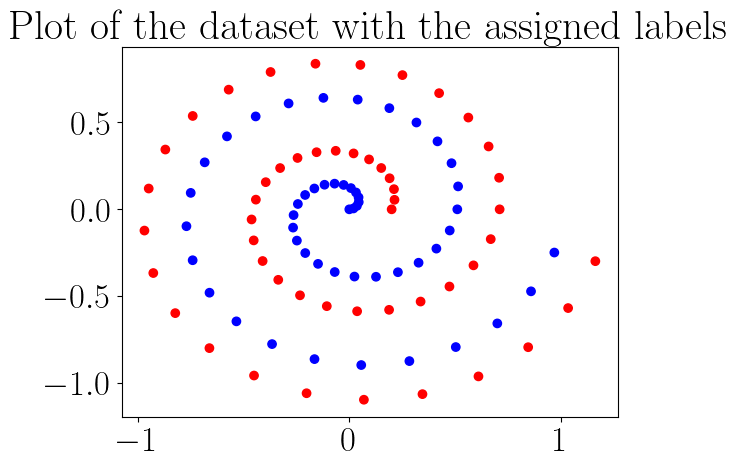

In [11]:
colors = ["r","b"]
c = [colors[i] for i in label.flatten().int()]
plt.scatter(data2d[:,0],data2d[:,1],c=c)
plt.title("Plot of the dataset with the assigned labels")
plt.show();

In [12]:
def regularization(alpha, model, model_type):
    # Regularization function as introduced in [1]
    n_layers = model.n_layers
    reg = 0
    
    if model_type=="HNN":
        for j in range(n_layers - 1):
            reg += alpha * model.h * (1 / 2 * torch.norm(model.B[j + 1] - model.B[j]) ** 2 +
                                    1 / 2 * torch.norm(model.C[j + 1] - model.C[j]) ** 2 +
                                    1 / 2 * torch.norm(model.b[j + 1] - model.b[j]) ** 2 + 
                                    1 / 2 * torch.norm(model.c[j + 1] - model.c[j]) ** 2)
    else:
        for j in range(n_layers - 1):
            reg += alpha * model.h * (1 / 2 * torch.norm(model.linearsA[j+1].weight - model.linearsA[j].weight) ** 2 +
                                    1 / 2 * torch.norm(model.linearsB[j+1].weight - model.linearsB[j].weight) ** 2 +
                                    1 / 2 * torch.norm(model.linearsA[j+1].bias - model.linearsA[j].bias) ** 2 + 
                                    1 / 2 * torch.norm(model.linearsB[j+1].bias - model.linearsB[j].bias) ** 2)
    return reg

In [13]:
class get_data(Dataset):
    def __init__(self, data, labels,dtype=torch.float32):
        if dtype==torch.float64:
            self.input = data.double()
            self.labels = labels.double()
        else:
            self.input = data
            self.labels = labels
        

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        input = self.input[idx]
        label = self.labels[idx]
        return input, label

In [14]:
def train_2d_example(model_type="HNN",nf=2, n_layers=10, t_end=1, epochs=150, gradient_info=False, seed=None, dtype=torch.float32):
    
    out = 1

    # Set seed
    if seed is None:
        seed = np.random.randint(10000)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # define data
    data_size = 8000
    train_data_size = 4000
    data2d, data_labels, domain = swiss_roll(data_size, nf=nf, shuffle=True)

    # # Select training parameters
    learning_rate = 5e-2
    
    # define network structure and optimizer
    batch_size = 125
    traininset = get_data(data2d[:data_size//2], data_labels[:data_size//2],dtype=dtype)
    testset = get_data(data2d[data_size//2:], data_labels[data_size//2:],dtype=dtype)
    trainloader = DataLoader(traininset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
    
    a,b = next(iter(testloader)) 
    input_for_gradients = a[0:1] #We evaluate the gradients only for this input
    h = t_end / n_layers

    if model_type=="HNN":
        model = HNN(n_layers=n_layers, nf=nf, h=h, dtype=dtype)
    elif model_type=="ResNet":
        model = ResNet(n_layers=n_layers, nf=nf, h=h, dtype=dtype)
    elif model_type=="MLP":
        model = MLP(n_layers=n_layers, nf=nf, h=h, dtype=dtype)
    else:
        print("Model not implemented")
        return
    model.to(device);
    
    criterion = nn.BCEWithLogitsLoss()

    steps = epochs * len(trainloader)
    max_lr = 5e-2
    min_lr = 1e-3

    optimizer = torch.optim.Adam(model.parameters(), lr=min_lr, weight_decay=0) 

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                            optimizer,
                            max_lr=max_lr,
                            div_factor= max_lr / min_lr,
                            total_steps=steps,
                            pct_start=0.4,
                            anneal_strategy="cos",
                        )

    progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

    stored_gradients = []

    for _ in progress_bar:
        
        for _, data in enumerate(trainloader):
            # Every data instance is an input + label pair
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            alpha = 1e-4
            loss += regularization(alpha, model, model_type)
            
            loss.backward()
            optimizer.step()
            
            scheduler.step()

            #Code adapted from https://github.com/DecodEPFL/HamiltonianNet/blob/master/examples/train_2d_example.py
            #We compute it for a random element in the batch for simplicity
            if gradient_info:
                data_point = input_for_gradients.clone()
                data_point.requires_grad = True
                matrix_aux = np.zeros([model.nf, model.nf, n_layers + 1])
                for k in range(model.nf):
                    _,states = model.dynamics(data_point,get_states=True)
                    YN = states[-1]
                    YN[0, k].backward() #get the gradients populated
                    for j in range(n_layers + 1):
                        matrix_aux[k, :, j] = states[j].grad.cpu().numpy()
                        states[j].grad = None
                inputs.requires_grad = False
                stored_gradients.append(matrix_aux)

        

        with torch.no_grad():
            counter = 0
            accuracy = 0.
            for i, data in enumerate(testloader):
                # Every data instance is an input + label pair
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                counter += 1
                predicted_classes = (outputs >= 0.5).int()
                accuracy += (predicted_classes == labels.flatten()).float().mean()
                
            formatted_accuracy = accuracy * 100 / counter
            progress_bar.set_postfix(test_accuracy=f"{formatted_accuracy:.2f}%")
            
    return model,data2d,data_labels,domain,trainloader,testloader,stored_gradients

In [15]:
model_type = "ResNet"

model,data2d,labels,domain,trainloader,testloader,stored_gradients = train_2d_example         (model_type=model_type,
        nf=4,
        n_layers=12, 
        t_end=1.2, 
        epochs=100, 
        gradient_info=True,
        dtype=torch.float32,
        seed=3)

Training Progress: 100%|██████████| 100/100 [00:18<00:00,  5.43epoch/s, test_accuracy=100.00%]


In [16]:
timestamp = time.strftime("%Y%m%d_%H%M%S") 

In [17]:
if not os.path.exists("FiguresHNNs"):
    os.mkdir("FiguresHNNs")

Are all the norms greater or equal than 1?  True


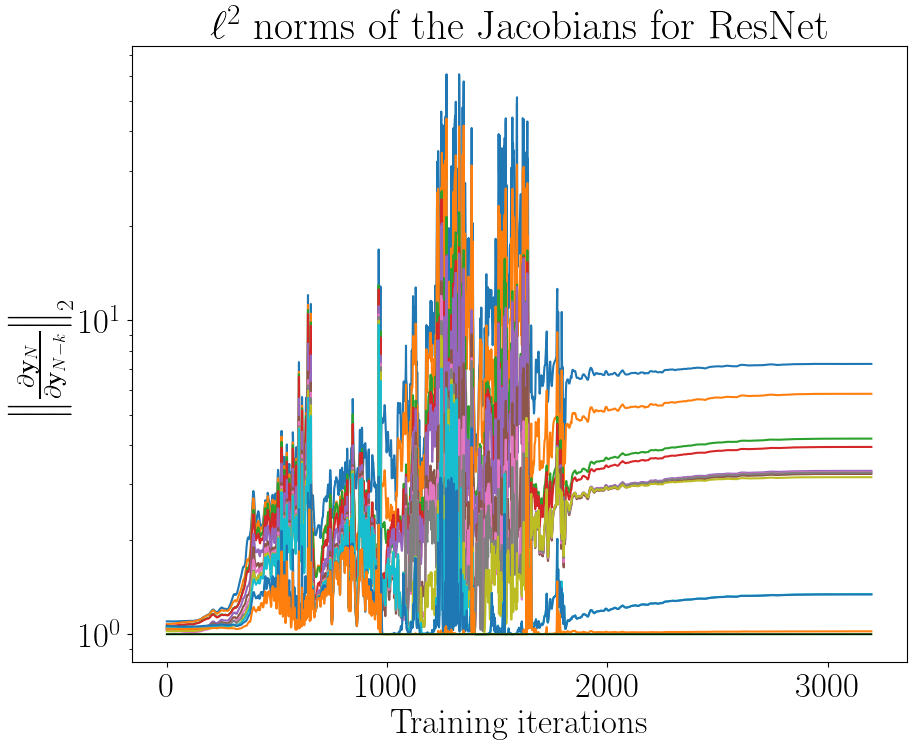

In [18]:
if len(stored_gradients)>0:
    
    fig = plt.figure(figsize=(10,8))
    check = []
    num_grads = len(stored_gradients)
    num_layers = len(stored_gradients[0][0,0])
    training_iterations = range(num_grads)
    for i in range(num_layers):
        norms_i = np.array([np.linalg.norm(g[:,:,i], ord=2) for g in stored_gradients])
        check.append((1.*(norms_i<1.)).sum()) #check if they all satisfy the desired criterion
        #print(f"Check {check[-1]/len(norms_i)}, i {i}")
        plt.semilogy(training_iterations, norms_i, c=f'C{i}')
        plt.semilogy(training_iterations[0], norms_i[0], c=f'C{i}',label=f"Activation {i}")
    plt.semilogy(training_iterations,np.ones_like(training_iterations),'k-',linewidth=1)
    plt.semilogy(training_iterations[0],1.,'k-',linewidth=1,label="Lower bound")
    
    plt.xlabel("Training iterations")
    plt.ylabel(r"$\left\|\frac{\partial \mathbf{y}_{N}}{\partial \mathbf{y}_{N-k}}\right\|_2$")
    #plt.legend(loc="center",bbox_to_anchor=(1.45,0.5),ncol=2)
    plt.title(rf"$\ell^2$ norms of the Jacobians for {model_type}")
    plt.savefig(f"FiguresHNNs/gradientNorms_{model_type}_{timestamp}.pdf",bbox_inches='tight')

    print("Are all the norms greater or equal than 1? ",sum(check)==0.)

In [24]:
model.eval();
model.to('cpu');

if not os.path.exists("savedModels"):
    os.mkdir("savedModels")

torch.save(model.state_dict(), f"savedModels/trainedModel_{timestamp}.pt")

In [20]:
with torch.no_grad():
    counter = 0
    accuracy = 0.
    for i, data in enumerate(testloader):
        # Every data instance is an input + label pair
        test_inputs, test_labels = data
        outputs = model(test_inputs)
        counter += 1
        predicted_classes = (outputs >= 0.5).int()
        accuracy += (predicted_classes == test_labels.flatten()).float().mean()
    test_accuracy = accuracy * 100 / counter
    print(f"Obtained test accuracy: {test_accuracy:.2f}%")

Obtained test accuracy: 100.00%


### Plot decision boundary

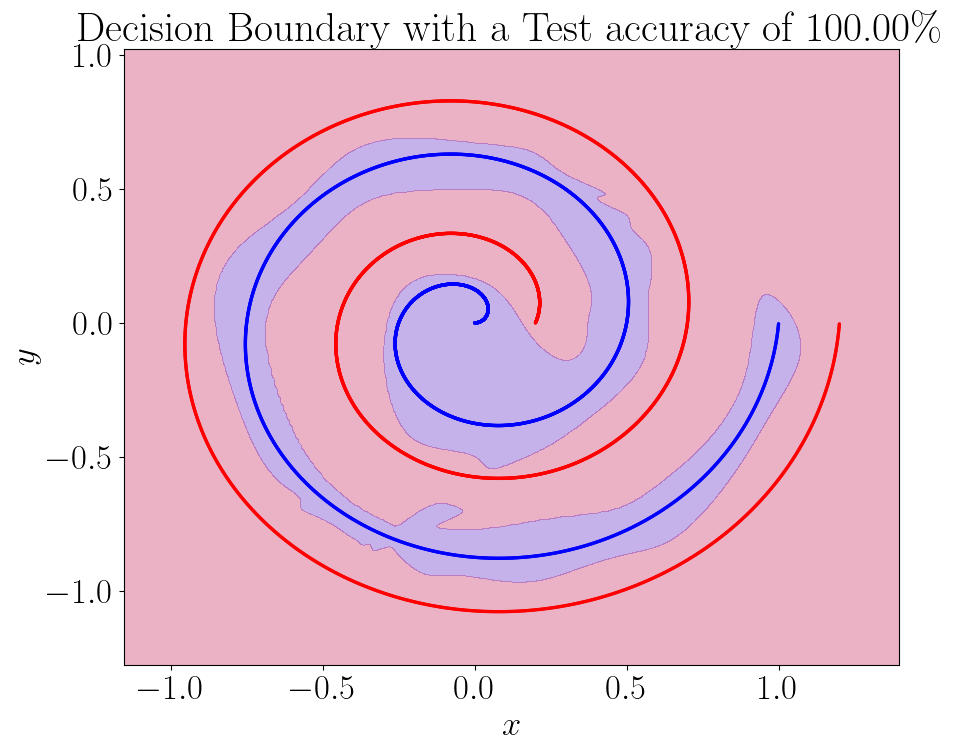

In [21]:
# Generate a mesh grid for plotting decision boundary
x_min, x_max = domain[0], domain[1]
y_min, y_max = domain[2], domain[3]
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Evaluate model on the grid
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
grid = _data_extension(grid, model.nf)
model.eval()
with torch.no_grad():
    zz = model(grid)
    zz = zz.view(xx.shape)

colors = ["r","b"]
c = [colors[i] for i in labels.flatten().int()]

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

data = data2d.detach().cpu().numpy()
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, torch.sigmoid(zz).numpy(), cmap=custom_cmap, alpha=0.3, levels=[0, 0.5, 1])  # Decision boundary
plt.scatter(data[:,0],data[:,-1],c=c,s=2)
plt.title(f'Decision Boundary with a Test accuracy of {test_accuracy:.2f}\%')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.savefig(f"FiguresHNNs/decisionBoundary_{model_type}_{timestamp}.pdf",bbox_inches='tight')

plt.show()

### Example to understand the retain grad specification

In [22]:
x = torch.randn(1,requires_grad=True)
lista = []
lista.append(x)
for i in range(5):
    x = 2 * x
    x.retain_grad()
    lista.append(x)

output = lista[-1]
output.backward()
[l.grad for l in lista]

[tensor([32.]),
 tensor([16.]),
 tensor([8.]),
 tensor([4.]),
 tensor([2.]),
 tensor([1.])]

In [23]:
x = torch.randn(1,requires_grad=True)
lista = []
lista.append(x)
for i in range(5):
    x = 2 * x
    #x.retain_grad()
    lista.append(x)

output = lista[-1]
output.backward()
[l.grad for l in lista]

/var/folders/dj/7f6tf39966b0v9zczs10jg_40000gn/T/ipykernel_12238/4217359176.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  [l.grad for l in lista]


[tensor([32.]), None, None, None, None, None]